# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Ефимов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [3]:
from copy import deepcopy

In [5]:
def get_batches_1(data, batch_size=50):
    itters = len(data) / batch_size
    for i in xrange(itters):
        yield data[i*batch_size:(i+1)*batch_size]
    if (i+1)*batch_size < len(data):
        yield data[(i+1)*batch_size:]

In [406]:
from sklearn.base import BaseEstimator, ClassifierMixin
import math
class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=50, verbose=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.verbose = verbose
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        def get_batches(data, batch_size=50):
            itters = len(data) / batch_size
            for i in xrange(itters):
                yield data[i*batch_size:(i+1)*batch_size]
            if (i+1)*batch_size < len(data):
                yield data[(i+1)*batch_size:]

        def sigma(z):
            return 1. / (1. + np.exp(-z))

        def evaluate_gradient(data, params, C):
            grad = np.zeros((len(params),))
            X1 = np.c_[np.ones(len(data)), data[:,:-1]]
            y = data[:,-1]
            #sigma(...) ~ sigma(Xw - y) -- vector of errors
            #X^T*sigma(...) from my formula
            reg_params = params*2./C/len(data)
            reg_params[0] = 0.
            grad = X1.T.dot((sigma(X1.dot(params)) - y)) / len(data) + reg_params
            return grad
        
#         params = np.random.randn(X.shape[1]+1)
        params = np.zeros(X.shape[1]+1)
        data = np.c_[X, y]
        X1 = np.c_[np.ones(len(X)), X]
        alpha = self.alpha
        batch_log = []
        epoch_log = []
        batch_count = 1
        error = -np.log(sigma(X1.dot(params))*(2*y - 1) + 1 - y).sum() / len(X)
        
        for i in xrange(self.max_epoch):
            if self.verbose:
                print 'epoch ', i
            np.random.shuffle(data)
            for batch in get_batches(data, self.batch_size):
                params_grad = evaluate_gradient(batch, params, self.C)
                params_old = params
                params = params - alpha * params_grad
     
                error_new = -np.log(sigma(X1.dot(params))*(2*y - 1) + 1 - y).sum() / len(X)
                if error_new < error:
                    alpha = alpha * 1.05
                else:
                    params = params_old
                    alpha = alpha * 0.5
                error = error_new

            epoch_log.append(-np.log(sigma(X1.dot(params))*(2*y - 1) + 1 - y).sum() / len(X))
            
        self.batch_log_ = batch_log
        self.epoch_log_ = epoch_log
        self.params_ = params
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        return (np.c_[np.ones(len(X)),X].dot(self.params_) > 0)*1
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        gx = np.c_[np.ones(len(X)),X].dot(self.params_)
        sigma_gx = 1. / (1. + np.exp(-gx))
        y_hat_proba = np.c_[1 - sigma_gx, sigma_gx]
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

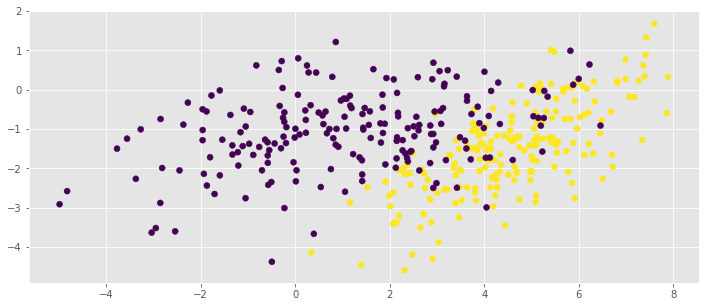

In [340]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

accuracy  0.8975


(-4.5792962388690981, 1.6761418633126512)

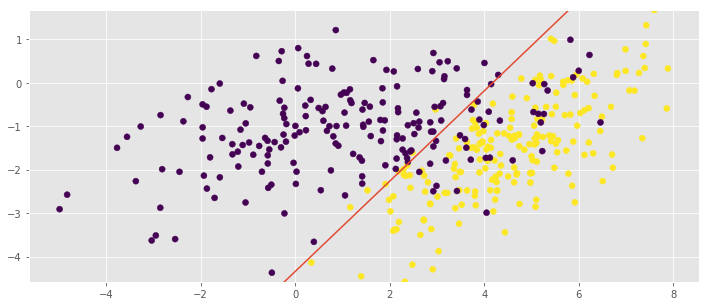

In [395]:
model = MySGDClassifier(max_epoch=300, alpha=1., batch_size=200)
model.fit(X, y)

print 'accuracy ', metrics.accuracy_score(y, model.predict(X))

xx = np.linspace(X[:,0].min(), X[:,0].max())
yy = -(model.params_[0] + model.params_[1]*xx) / model.params_[2]
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot(xx, yy)
plt.ylim(X[:,1].min(), X[:,1].max())

In [396]:
y_proba = model.predict_proba(X)

In [397]:
from sklearn.metrics import roc_curve, auc

In [398]:
fpr, tpr, _ = roc_curve(y, y_proba[:,0], pos_label=0)
roc_auc = auc(fpr, tpr)
print roc_auc

0.94455


## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

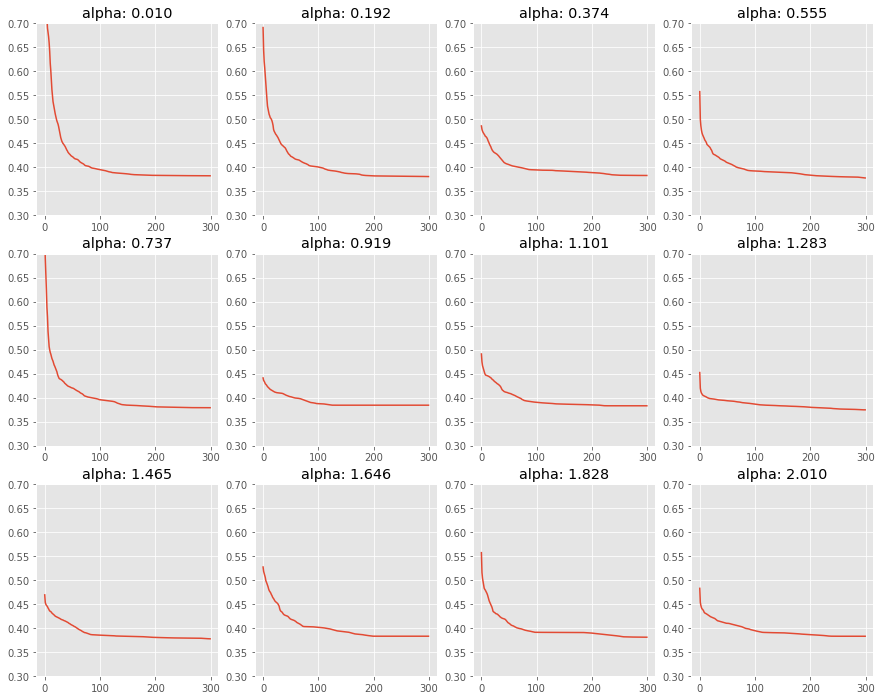

In [401]:
c = 1./11.
plt.figure(figsize=(15, 12))
for i in xrange(12):
    plt.subplot(3, 4, i+1)
    model = MySGDClassifier(max_epoch=300, alpha=c*i*2 + 0.01)
    model.fit(X, y)
    plt.ylim((0.3, 0.7))
    plt.title("alpha: %.3f"%(c*i*2 + 0.01))
    plt.plot(xrange(len(model.epoch_log_)), model.epoch_log_)
#     plt.plot([0, len(model.epoch_log_)], [0.38, 0.38], 'b')

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [105]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = 'trainingData_tabular/trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [106]:
df_data.shape

(2000000, 45)

In [107]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [108]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [109]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [110]:
df_data.opponent_hero_card_id.nunique()

9

In [111]:
df_data.player_hero_card_id.nunique()

9

In [112]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
ohe = OneHotEncoder(sparse=False)

In [114]:
new_feat = ohe.fit_transform(df_data.opponent_hero_card_id.values.reshape(-1,1))

In [115]:
df1 = pd.DataFrame(new_feat, columns=["opponent_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_data.index)
df_data = pd.concat([df_data, df1], axis=1)

In [116]:
new_feat = ohe.fit_transform(df_data.player_hero_card_id.values.reshape(-1,1))
df1 = pd.DataFrame(new_feat, columns=["player_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_data.index)
df_data = pd.concat([df_data, df1], axis=1)

In [117]:
del_cols = ["opponent_hero_card_id", "player_hero_card_id"]
cols = [x for x in df_data.columns if x not in del_cols]
df_data = df_data[cols]

In [118]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1.0,1.0,1.0,1.0,0.0
turn,14.0,7.0,5.0,8.0,13.0
opponent_armor,0.0,0.0,3.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,5.0,22.0,29.0,26.0,30.0
opponent_special_skill_used,0.0,0.0,0.0,0.0,0.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,6.0,4.0,7.0,10.0
opponent_crystals_current,10.0,6.0,1.0,7.0,1.0
opponent_deck_count,11.0,19.0,22.0,17.0,12.0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [119]:
cols = df_data.columns

In [120]:
X_train = df_data[cols[1:]].values

In [121]:
y_train = df_data.decision.values

In [347]:
print X_train.shape

(2000000, 59)


In [414]:
model_h = MySGDClassifier(max_epoch=15, alpha=1., batch_size=400, verbose=True)

In [415]:
model_h.fit(X_train, y_train)

epoch  0


/Users/vladislavefimov/my-venv/bin/lib/python2.7/site-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in log


epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14


MySGDClassifier(C=1, alpha=1.0, batch_size=400, max_epoch=15, verbose=True)

In [357]:
from sklearn import metrics

In [423]:
y_proba = model.predict_proba(X_train)

In [424]:
fpr, tpr, _ = roc_curve(y_train, y_proba[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
print roc_auc

0.778594367656


## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [195]:
df_test = pd.read_csv('./testData_tabular.csv')
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

In [196]:
new_feat = ohe.fit_transform(df_test.opponent_hero_card_id.values.reshape(-1,1))
df1 = pd.DataFrame(new_feat, columns=["opponent_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_test.index)
new_feat1 = ohe.fit_transform(df_test.player_hero_card_id.values.reshape(-1,1))
df2 = pd.DataFrame(new_feat1, columns=["player_hero_id_"+str(i+1) for i in xrange(new_feat1.shape[1])], index=df_test.index)
df_test = pd.concat([df_test, df1, df2], axis=1)

In [197]:
del_cols = ["opponent_hero_card_id", "player_hero_card_id"]
cols = [x for x in df_test.columns if x not in del_cols]
df_test = df_test[cols]

In [198]:
X_test = df_test[cols[1:]].values

In [203]:
X_test.shape

(750000, 59)

In [418]:
y_proba = model.predict_proba(X_test)

In [419]:
y_proba.shape

(750000, 2)

In [420]:
with open('out3.dat', 'w') as f:
    f.write('\n'.join(str(x) for x in y_proba[:,1]))

In [421]:
f.close()

sir_Krabye -- 0.787